In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%load_ext autoreload
%autoreload 2

import sys
print(sys.executable)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\Livia\.conda\envs\glm\python.exe


In [16]:
input_dir = r'\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output' # windows
plot_df = pd.read_csv(os.path.join(input_dir, 'df.csv'))
y = pd.read_csv(os.path.join(input_dir, 'y.csv'))

drop_list = {'AB_cue_L', 'AB_cue_R'}
for dropper in drop_list:
    plot_df = plot_df.drop(dropper, axis=1)

In [17]:
plot_df.head()

,trial_num_new,aB_cue_R,AA_cue_R,Ab_cue_R,aa_cue_R,Aa_cue_R,aB_cue_L,AA_cue_L,Ab_cue_L,aa_cue_L,...,Consumption_R_R,Consumption_UR_R,Consumption_R_L,Consumption_UR_L,Cons_more_R_R,Cons_more_R_L,Cons_more_UR_R,Cons_more_UR_L,Cons_more_switchUR_R,Cons_more_switchUR_L
0,3759.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3759.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3759.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3759.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3759.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# def plot_av_coef(config, df(X_test), enl, y):
def first_cue(trial, cues):
    
    cuetype = None
    for cue in cues:
        # print(cue)
        # print(np.where(trial[cue] == 1)[0])
        if len(np.where(trial[cue] == 1)[0]) > 0:
            cuetype = str(cue)
            time = np.where(trial[cue] == 1)[0][0]
            break
          
    if cuetype is None:
        print("no cue found - big problem")
        return cuetype, 0
    else:
        return cuetype, time

In [19]:
cols_to_plot = [col for col in plot_df.columns if not 'trial' in col]
enl_columns = [col for col in plot_df.columns if 'enl' in col]
not_more = [col for col in plot_df.columns if not 'more' in col]
cues = [col for col in plot_df.columns if 'cue' in col]
not_ = [col for col in not_more if (not 'enl' in col) and (not 'trial' in col)]
print(not_)

['aB_cue_R', 'AA_cue_R', 'Ab_cue_R', 'aa_cue_R', 'Aa_cue_R', 'aB_cue_L', 'AA_cue_L', 'Ab_cue_L', 'aa_cue_L', 'Aa_cue_L', 'Select_R', 'Select_L', 'Consumption_R_R', 'Consumption_UR_R', 'Consumption_R_L', 'Consumption_UR_L']


In [20]:
plot_df[['y_pred', 'y_real']] = y[['y_pred', 'y_real']].copy()

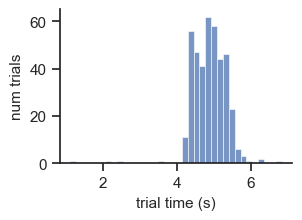

In [21]:
fig, ax = plt.subplots(figsize=(3,2))
sns.histplot(plot_df.trial_num_new.value_counts()*(1/48.44), ax=ax)
ax.set(xlabel='trial time (s)', ylabel='num trials')
sns.despine()

In [22]:
trial_ids, count = np.unique(plot_df.trial_num_new, return_counts=True)
length = np.max(count)
averaged_event_df = pd.DataFrame()
real_event_df = pd.DataFrame()
    
for trial_num, t_ in plot_df.groupby('trial_num_new'):
    # trial = plot_df[plot_df.index == trial_num]
    y_trial = t_['y_pred']
    y_real = t_['y_real']
    trial = t_.copy().drop(labels=['y_pred', 'y_real'], axis='columns')
    # print(y_trial.shape, trial.shape)
    
    nones = []
    for col in not_:    
        if np.any((np.where(trial[col] == 1))[0]):  # cb: find event idcs for each trial
            cue_type, first_cue_ind = first_cue(trial, cues)
            if cue_type is None:
                nones.append([trial_num, col])
                #is this enl are they their own trials??
            # print(f"{cue_type}: {first_cue_ind}")
            
            event_new = y_trial[first_cue_ind:len(trial[col])] #HERE
            event_real = y_real[first_cue_ind:len(trial[col])]
            
            if col in averaged_event_df:
                a = averaged_event_df[col].values
                b = event_new
                b_nans = np.append(event_new, np.full(abs(len(b) - len(a)), np.nan))
                    
                mean_result = np.nanmean([a, b_nans], axis=0)  
            else:
                mean_result = event_new
                
            if col in real_event_df:
                c = real_event_df[col].values
                d = event_real
                d_nans = np.append(event_real, np.full(abs(len(d) - len(c)), np.nan))
                mean_real = np.nanmean([c, d_nans], axis=0)
            else:
                mean_real = event_real

            mean_result = np.append(mean_result, np.full(abs(length - len(mean_result)), np.nan))
            mean_real = np.append(mean_real, np.full(abs(length - len(mean_real)), np.nan))
            

            averaged_event_df[col] = mean_result  
            real_event_df[col] = mean_real          
            # print(f"shapes: {col, averaged_event_df[col].shape, len(mean_result)}")
            
    if len(nones) > 0:
        print(f"no cues?: {nones}") 

C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of em

no cue found - big problem
no cue found - big problem
no cues?: [[4203.0, 'Select_R'], [4203.0, 'Consumption_R_R']]
no cue found - big problem
no cue found - big problem
no cues?: [[4455.0, 'Select_L'], [4455.0, 'Consumption_R_L']]
no cue found - big problem
no cue found - big problem
no cues?: [[4565.0, 'Select_L'], [4565.0, 'Consumption_R_L']]


C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of em

no cue found - big problem
no cues?: [[4790.0, 'Select_R']]
no cue found - big problem
no cue found - big problem
no cues?: [[4795.0, 'Select_R'], [4795.0, 'Consumption_UR_L']]


C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of empty slice
  mean_result = np.nanmean([a, b_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:38: RuntimeWarning: Mean of empty slice
  mean_real = np.nanmean([c, d_nans], axis=0)
C:\Users\Livia\AppData\Local\Temp\ipykernel_28104\1588424664.py:30: RuntimeWarning: Mean of em

16
Index(['Aa_cue_R', 'Select_L', 'AA_cue_L', 'Consumption_R_L', 'aa_cue_R',
       'Consumption_UR_L', 'AA_cue_R', 'Select_R', 'Consumption_R_R',
       'aB_cue_R', 'aa_cue_L', 'Consumption_UR_R', 'Aa_cue_L', 'aB_cue_L',
       'Ab_cue_L', 'Ab_cue_R'],
      dtype='object')


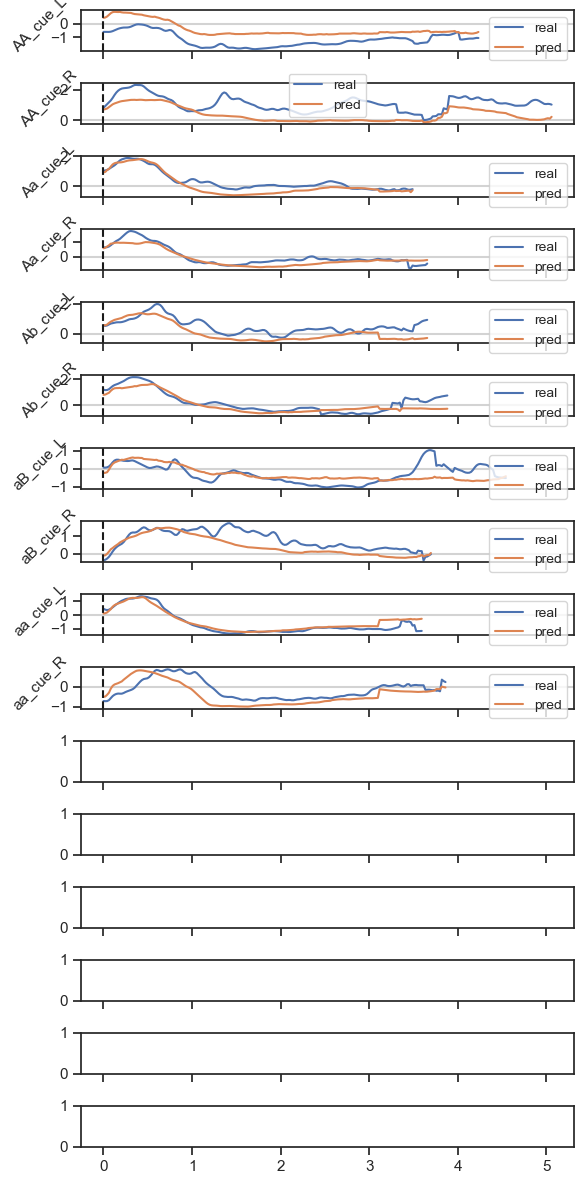

In [23]:
fig, ax = plt.subplots(len(averaged_event_df.columns), figsize=(6, 12), sharex=True)
print(len(averaged_event_df.columns))
print(averaged_event_df.columns)

for i, av in enumerate(np.sort(cues)): #cue select comsp: R, UR
    t = np.arange(0, len(averaged_event_df[av])) / 48.440600198412696
    t_real = np.arange(0, len(real_event_df[av])) / 48.440600198412696
    ax[i].axhline(y=0, color='lightgrey')
    ax[i].plot(t_real, real_event_df[av], label='real')
    ax[i].plot(t, averaged_event_df[av], label='pred')
    ax[i].set_ylabel(av, rotation = 45)
    ax[i].axvline(x=0, color='k', linestyle="--")
    ax[i].legend()
ax[0].set(
    # title=f"Averaged signal reconstruction: {project_name}"
)
plt.tight_layout()

# Alternative method

In [24]:
# Load in both dfs.
input_dir = r'\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output' # windows
plot_df = pd.read_csv(os.path.join(input_dir, 'df.csv'))
y = pd.read_csv(os.path.join(input_dir, 'y.csv'))

drop_list = {'AB_cue_L', 'AB_cue_R'}
for dropper in drop_list:
    plot_df = plot_df.drop(dropper, axis=1)


In [25]:


# Copied from above -- list come cols to plot, but add in exclusion of trial column.
cols_to_plot = [col for col in plot_df.columns if 'trial' not in col]
enl_columns = [col for col in plot_df.columns if 'enl' in col]
not_more = [col for col in plot_df.columns if not 'more' in col]
cues = [col for col in plot_df.columns if 'cue' in col]
not_ = [col for col in not_more if (not 'enl' in col) and (not 'trial' in col)]
print(not_)

['aB_cue_R', 'AA_cue_R', 'Ab_cue_R', 'aa_cue_R', 'Aa_cue_R', 'aB_cue_L', 'AA_cue_L', 'Ab_cue_L', 'aa_cue_L', 'Aa_cue_L', 'Select_R', 'Select_L', 'Consumption_R_R', 'Consumption_UR_R', 'Consumption_R_L', 'Consumption_UR_L']


In [26]:
# Use different trial column label to match plotting functions' expectations.
plot_df = plot_df.rename(columns={'trial_num_new':'nTrial'})

# Add padding between real data and glm copies so there is no overlap.
padding = pd.DataFrame({'nTrial':[plot_df.nTrial.max()+1]*1000})
plot_df = pd.concat((plot_df, padding)).reset_index(drop=True)

# Mimic some columns for plotting functions.
plot_df['session'] = 'tmp'  # won't be used

# Will only be used in relative sense I think, need to double check. Obviously if
# this is used otherwise it will cause problems to write like this when trials have
# been randomly sampled.
plot_df['session_clock'] = 1/48.440600198412696  
plot_df['session_clock'] = plot_df.session_clock.cumsum()
plot_df['source'] = 'mouse data'  # label data source
plot_df['y'] = y['y_real'].copy()  # tack on photometry data, which should already be aligned

# Mimic trial dataframe, which basically just needs to match trial IDs with timeseries.
trials = pd.DataFrame({'nTrial':plot_df.nTrial.unique()})
trials['session'] = 'tmp'
trials['source'] = 'mouse data'  # Needs to match data source (actually only this one is important)

# Copy the above, but tack on the model predicions and assign unique trial IDs.
plot_df_model = plot_df.copy()
plot_df_model['source'] = 'glm'
plot_df_model['y'] = y['y_pred'].copy()
plot_df_model['nTrial'] += plot_df.nTrial.max()
trials_model = trials.copy()
trials_model['nTrial'] += trials.nTrial.max()
trials_model['source'] = 'glm'

# Merge the two sets of dfs so each contains "trials" with real and predicted 
# photometry (but the same behavioral events).
plot_df = pd.concat((plot_df, plot_df_model)).reset_index(drop=True)
trials = pd.concat((trials, trials_model)).reset_index(drop=True)

In [27]:
win = (1,6) #2.5)  # setting window length to not span beyond any trial limits relative to any event
sys.path.append("C:\\Users\\Livia\\Desktop\\photometry_liv\\photometry_preprocessing\\neural-timeseries-analysis")
from nta.visualization import avg_plots
from nta.events import align

for epoch in not_:
    trials = align.align_photometry_to_event(trials, plot_df, channel='y',
                                             aligned_event=epoch, window=win, quantify_peaks=False) #,
                                             #ignore_precautions=True)  # added this to allow for broken trial continuity, but it's risky

 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz
 no sampling frequency provided, using 48.44 Hz


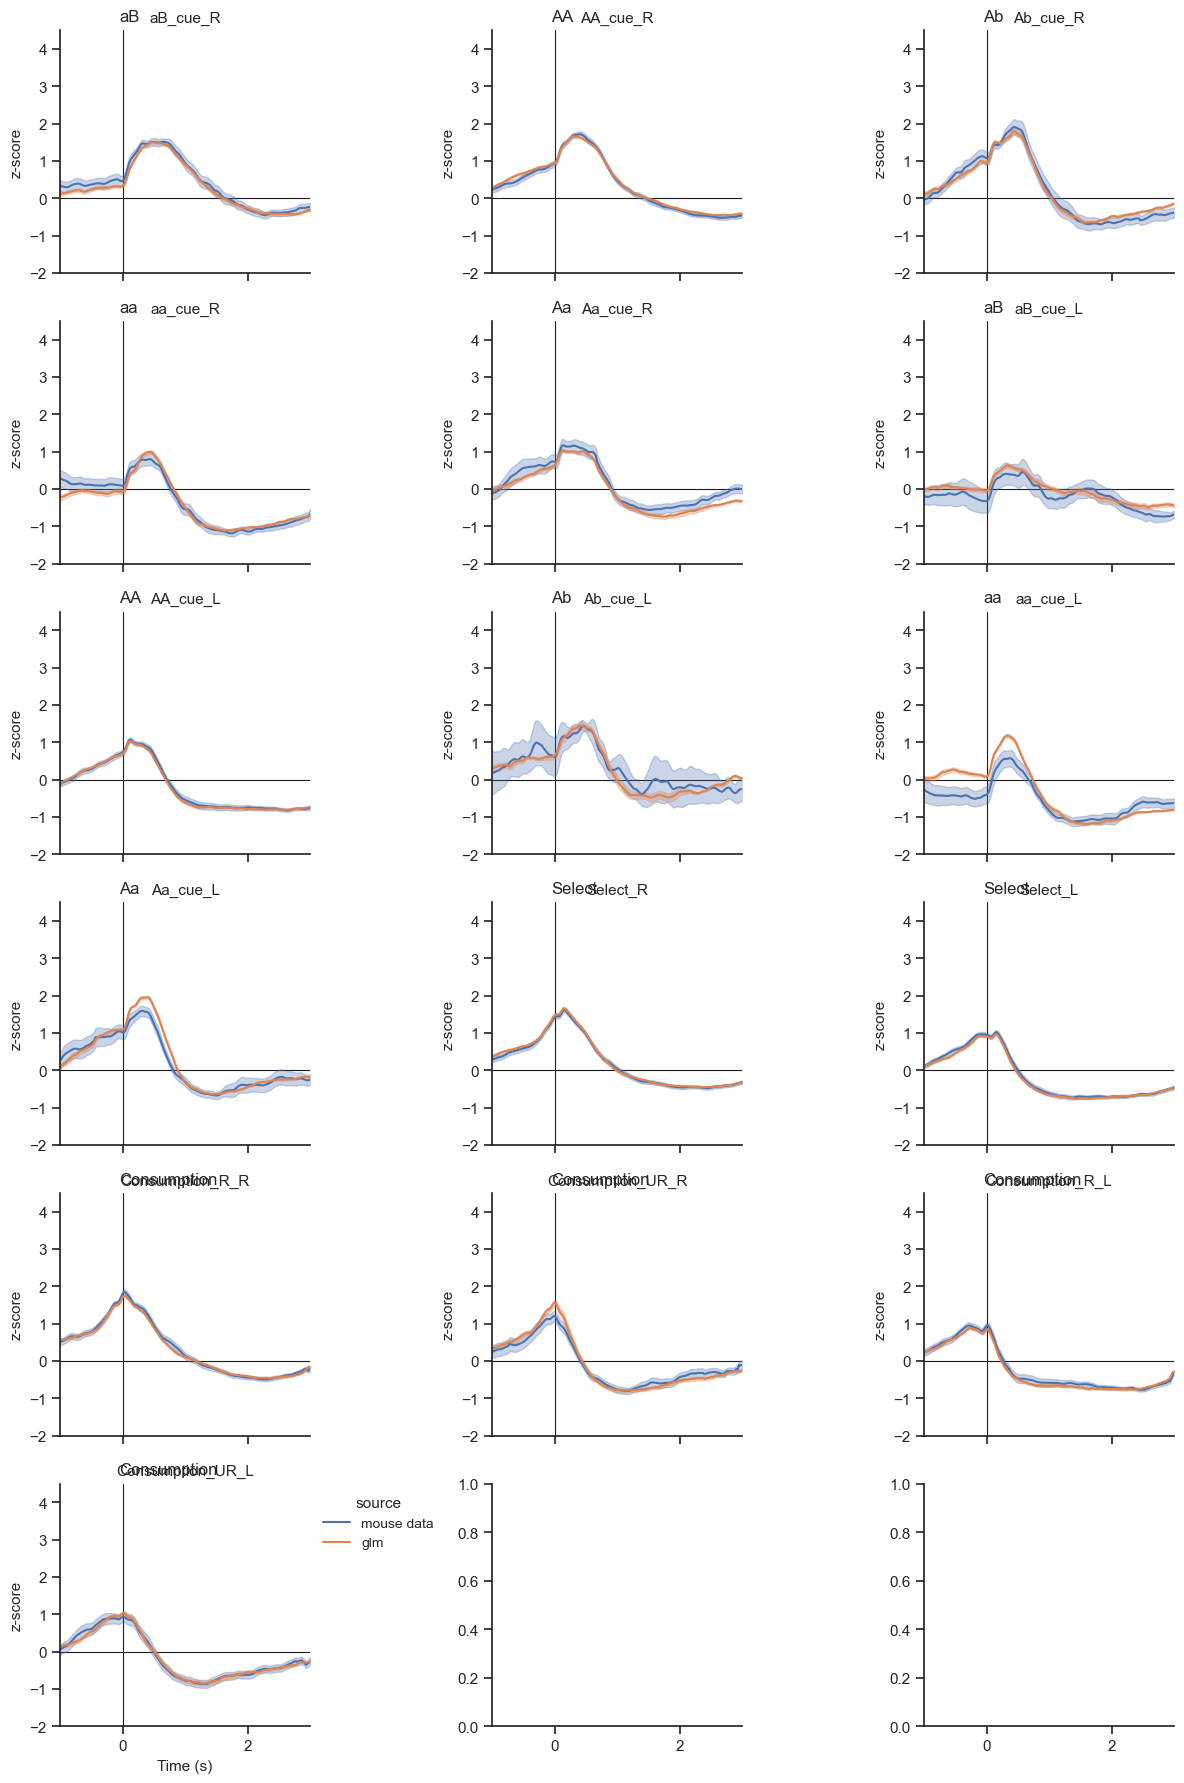

In [28]:
model_pal = {'glm': sns.color_palette(n_colors=2)[0], 'mouse data': sns.color_palette(n_colors=2)[1]}
fig, ax = avg_plots.plotting_wrapper(trials,
                        alignment_states = not_,
                        column='source',
                        channel='y',
                        cmap_color=model_pal,
                        window=(1,3), #2.5),
                        ylim=(-2, 4.5),
                        error='se',
                        save=False)
[ax_.set(title=event) for ax_, event in zip(ax.flatten(), not_)]

import os
project_dir = r'\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Livia\\glm_output' # windows
project_name = 'T430_newLatCue_glm' #'D1_h3Hist_all_glm' 
save_img = os.path.join(project_dir, project_name)
plt.savefig(save_img + '/results/avg_reconstructions.png')
